<a href="https://colab.research.google.com/github/Weimw/movielens-project/blob/main/CS224w_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommender System based on LightGCN

## 1. Install Packages and Libraries

In [129]:
# Install required packages.
%%capture
import torch
import os
os.environ['TORCH'] = torch.__version__
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [130]:
# import required modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch import Tensor, nn, optim
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.utils import structured_negative_sampling
from torch_sparse import SparseTensor, matmul

## 2. Data Preprocessing

MovieLens 100k is a well-known movie recommendation dataset that contains 100,000 movie ratings from 943 users on 1,682 movies. Each user has rated at least 20 movies on a scale of 1 to 5, and the data is provided in a matrix format where each row represents a user and each column represents a movie. The dataset also includes additional information such as movie genre and release year. MovieLens 100k is often used as a benchmark for evaluating movie recommendation models and algorithms.

In [131]:
# download the dataset
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


The `ratings.csv` dataset links users (identified by `userId`) and movies (identified by `movieId`). Our initial objective is to construct a dictionary that maps each entry's ID to a unique value within the range `{ 0, ..., num_rows - 1 }`. This mapping is beneficial since it reduces the size of the adjacency matrix. We then generate an `edge_index` matrix from `ratings.csv` with dimensions `[2, num_ratings]`. The first row contains the mapped userId, while the second row has the mapped `movieId`. A specific column corresponds to a connection (or rating) between a user and a movie. The `edge_index` tensor is a crucial component for message propagation throughout the graph network.


In [132]:
def preprocessing(movie_path, rating_path): 
  '''
    Parameters:
         movie_path (str): A string representing the file path to the movies dataset.
         rating_path (str): A string representing the file path to the ratings dataset.
    
    Returns:
         edge_index (torch.Tensor): the indices of edges in the adjacency matrix for the ratings dataset.
         num_users (int): number of unique users in the ratings dataset.
         num_movies (int): number of unique movies in the ratings dataset.
         user_mapping (pd.DataFrame): the list that map user id to continguous new ids
         movie_df (pd.DataFrame): the movie dataset
         rating_df (pd.DataFrame): the rating dataset
  '''
  # load movies and ratings dataset
  movie_df = pd.read_csv(movie_path, index_col = 'movieId')
  rating_df = pd.read_csv(rating_path, index_col = 'userId') 

  # create mapping to continous range
  movie_mapping = {idx: i for i, idx in enumerate(movie_df.index.unique())}
  user_mapping = {idx: i for i, idx in enumerate(rating_df.index.unique())}
  num_users, num_movies = len(rating_df.index.unique()), len(movie_df.index.unique())

  rating_df = pd.read_csv(rating_path)
  edge_index = None
  users = [user_mapping[idx] for idx in rating_df['userId']]
  movies = [movie_mapping[idx] for idx in rating_df['movieId']]

  # filter for edges with a high rating
  ratings = rating_df['rating'].values
  recommend_bool = torch.from_numpy(ratings).view(-1, 1).to(torch.long) >= 4

  edge_index = [[],[]]
  for i in range(recommend_bool.shape[0]):
    if recommend_bool[i]:
      edge_index[0].append(users[i])
      edge_index[1].append(movies[i])
    
  edge_index = torch.tensor(edge_index)
  return edge_index, num_users, num_movies, \
  movie_mapping, user_mapping, movie_df, rating_df

In [133]:
edge_index, num_users, num_movies, \
movie_mapping, user_mapping, \
movie_df, rating_df = preprocessing(movie_path, rating_path)

### A peek into the MovieLens 100K dataset

Let's take a look into the MovieLens dataset. We can see the `movie.csv` has the following format: `movieId title genres`



In [134]:
# format for movie 
movie_df.head(10)

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action


The `rating.csv` has the following format of `userId, movieId, rating, timestamp`. For the raitng prediction task, we only need the first three fields for the purpose of our task.

In [135]:
# format for ratings
rating_df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


We also need to know the rating scales because we need to determine beyond what scores we can say that a user likes the movies. 

In [136]:
# what are the ratings
sorted(pd.unique(rating_df['rating']))

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

### Prepare datasets

Next, we divide the complete dataset into training, validation, and testing sets. The partition is made based on the edges in the graph. More specifically, we randomly separate the data into three groups with an 80/10/10 split ratio. This implies that each group will contain a portion of the `edge_index` subset.

In [137]:
# split the edges into train set and test set 
num_ratings = edge_index.shape[1]
rating_indices = np.arange(num_ratings)

indices_train, indices_val_test = train_test_split(rating_indices, test_size = 0.2, random_state = 42)
indices_val, indices_test = train_test_split(indices_val_test, test_size = 0.5, random_state = 42)

# slice the whole dataset by split indices, then convert to SparseTensor for later training
def generate_edge(edge_indices):
  '''
  Paramters:
      edge_indices (np.ndarray): An array representing the indices of edges in the dataset.

  Returns:
      sub_edge_index (torch.Tensor): indices of edges in the specified subset.
      edge_index_sparse (SparseTensor): A sparse tensor representing the adjacency matrix for the subset of edges.
  '''
  sub_edge_index = edge_index[:, edge_indices]
  num_nodes = num_users + num_movies
  edge_index_sparse = SparseTensor(row = sub_edge_index[0],
                                   col = sub_edge_index[1],
                                   sparse_sizes = (num_nodes, num_nodes))
  return sub_edge_index, edge_index_sparse

train_edge_index, train_sparse_edge_index = generate_edge(indices_train)
val_edge_index, val_sparse_edge_index = generate_edge(indices_val)
test_edge_index, test_sparse_edge_index = generate_edge(indices_test)

During the training phase, we will use mini-batches and select a number of positive and negative edges within each batch. Positive edges refer to observed or training user-item interactions. We aim to punish negative edges during training by allocating them with a greater loss. To achieve this, we will make use of the PyG function called `structured_negative_sampling,` which selects a negative edge for every positive edge in the graph as defined by `edge_index`.

In [138]:
edges = structured_negative_sampling(train_edge_index)
edges = torch.stack(edges, dim=0)
edges

tensor([[ 408,  579,    2,  ...,  482,   15,  205],
        [ 863,  990, 3734,  ..., 5729,  561,  621],
        [2367,  403, 3601,  ..., 8985, 6159, 1129]])

In [139]:
def mini_batch_sample(batch_size, edge_index):
    """
    Randomly samples indices of a minibatch given an adjacency matrix.
    These tensors represent the indices of the sampled minibatch, where:
    - user indices: indices of the users in the sampled edges
    - positive item indices: indices of the positive items in the sampled edges
    - negative item indices: indices of the negative items in the sampled edges

    Parameters:
    batch_size (int): The desired minibatch size.
    edge_index (torch.Tensor): A 2 by N tensor representing the edges.

    Returns:
    user indices, positive item indices, negative item indices (torch.Tensor)
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = torch.randperm(edges.shape[1])[:batch_size]
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

## 3.Model Architecture

LightGCN is a recommender system model that belongs to the family of graph convolutional networks (GCNs). The primary objective of LightGCN is to provide personalized recommendations by exploiting the user-item interaction graph's structure. Unlike other graph-based recommendation methods that use complex graph neural networks (GNNs), LightGCN omits the feature transformation and non-linearity, which requires fewer parameters and has a faster training time. The model's architecture involves performing several layers of graph convolutions to propagate user-item embeddings, which are then used to generate personalized recommendations. LightGCN has demonstrated competitive performance in terms of recommendation quality while being computationally efficient. For more information, you can find the [orginal paper](https://arxiv.org/pdf/2002.02126.pdf) here.

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Encoder and Decoder
The LightGCN model's only adjustable parameters are the initial embeddings for each user and item in the 0-th layer, denoted as $e_u^{(0)}$ and $e_i^{(0)}$, respectively. The final embeddings for all users and items, represented as $e_u$ and $e_i$, are created by merging the embeddings acquired at each propagation layer using the following formula.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}


In [140]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """
    LightGCN Model, see reference: https://arxiv.org/abs/2002.02126
    We omit a dedicated class for LightGCNConvs for easy access to embeddings
    """

    def __init__(self, num_users, num_items, hidden_dim, num_layers):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.users_emb = nn.Embedding(self.num_users, self.hidden_dim)
        self.items_emb = nn.Embedding(self.num_items, self.hidden_dim)

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index):
        """
        Forward pass of the LightGCN model. Returns the init and final
        embeddings of the user and item
        """
        edge_index_norm = gcn_norm(edge_index, False)

        # The first layer, concat embeddings
        x0 = torch.cat([self.users_emb.weight, self.items_emb.weight])
        xs = [x0]
        xi = x0

        # pass x to the next layer
        for i in range(self.num_layers):
            xi = self.propagate(edge_index_norm, x=xi)
            xs.append(xi)

        xs = torch.stack(xs, dim=1)
        x_final = torch.mean(xs, dim=1)

        users_emb, items_emb = \
        torch.split(x_final, [self.num_users, self.num_items])

        return users_emb, self.users_emb.weight, items_emb, self.items_emb.weight

    def message(self, x):
        return x

    def propagate(self, edge_index, x):
        x = self.message_and_aggregate(edge_index, x)
        return x

    def message_and_aggregate(self, edge_index, x):
        return matmul(edge_index, x)


## Loss Function


The model's training objective in LightGCN is based on a pairwise Bayesian Personalized Ranking (BPR) loss. This loss aims to ensure that the model's predictions for positive samples are higher than those for negative samples for each user. The BPR loss function is defined as follows:

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2 
\end{equation}

$\hat{y}_{u}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: L-2 regularization strength

In [141]:
def bpr_loss(users_emb, user_emb_0, pos_emb, pos_emb_0, neg_emb, neg_emb_0, lambda_val):
    """
    Calculate the Bayesian Personalzied Ranking loss.

    Parameters:
    users_emb (torch.Tensor): The final output of user embedding
    user_emb_0 (torch.Tensor): The initial user embedding
    pos_emb (torch.Tensor):  The final positive item embedding 
    pos_emb_0 (torch.Tensor): The initial item embedding
    neg_emb (torch.Tensor): The final negtive item embedding
    neg_emb_0 (torch.Tensor): The inital negtive item embedding
    lambda_val (float): L2 regulatization strength

    Returns:
    loss (float): The BPR loss
    """
    pos_scores = torch.sum(users_emb * pos_emb, dim=1) 
    neg_scores = torch.sum(users_emb * neg_emb, dim=1)
    losses = -torch.log(torch.sigmoid(pos_scores - neg_scores))
    loss = torch.mean(losses) + lambda_val * \
    (torch.norm(users_emb_0) + torch.norm(pos_emb_0) + torch.norm(neg_emb_0))
    
    return loss

## 4.Evaluation Metrics

The evaluation metric we will use is **Recall@K**, it is defined as the proportion of relevant items that are recommended to a user among the top-K items recommended by the algorithm. \\
For each user $u$, \\
Let $P_{u}$ be a set of positive items the user will interact in the future. \\
Let $R_{u}$ be a set of items recommended by the model, in top-K recommendation, $|R_{u}| = K$. Items that users has already interacted are excluded.

![picture](https://drive.google.com/uc?id=1Ea3_y0eLNNKZT2p13Sa-umZccVuNtRvo)

**Recall@K** for user $u$ is $|P_{u}\cap R_{u}| / |P_{u}|$. \\
The final Recall@K is computed by averaging the recall values across all users.


In [142]:
def evaluation(model, edge_index, sparse_edge_index, mask_index, k, lambda_val):
    """
    Evaluates model loss and metrics including recall, precision on the 
    Parameters:
    model: LightGCN model to evaluate.
    edge_index (torch.Tensor): Edges for the split to evaluate.
    sparse_edge_index (torch.SparseTensor): Sparse adjacency matrix.
    mask_index(torch.Tensor): Edges to remove from evaluation, in the form of a list.
    k (int): Top k items to consider for evaluation.

    Returns: loss, recall, precision
        - loss: The loss value of the model on the given split.
        - recall: The recall value of the model on the given split.
        - precision: The precision value of the model on the given split.
    """
    # get embeddings and calculate the loss
    users_emb, users_emb_0, items_emb, items_emb_0 = model.forward(sparse_edge_index)
    edges = structured_negative_sampling(edge_index, contains_neg_self_loops=False)
    
    user_indices, pos_indices, neg_indices = edges[0], edges[1], edges[2]
    users_emb, users_emb_0 = users_emb[user_indices], users_emb_0[user_indices]
    pos_emb, pos_emb_0 = items_emb[pos_indices], items_emb_0[pos_indices]
    neg_emb, neg_emb_0 = items_emb[neg_indices], items_emb_0[neg_indices]

    loss = bpr_loss(users_emb, users_emb_0, pos_emb, pos_emb_0,
                    neg_emb, neg_emb_0, lambda_val).item()

    users_emb_w = model.users_emb.weight
    items_emb_w = model.items_emb.weight

    # set ratings matrix between every user and item, mask out existing ones
    rating = torch.matmul(users_emb_w, items_emb_w.T)

    for index in mask_index:
        user_pos_items = get_positive_items(index)
        masked_users = []
        masked_items = []
        for user, items in user_pos_items.items():
            masked_users.extend([user] * len(items))
            masked_items.extend(items)

        rating[masked_users, masked_items] = float("-inf")

    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users and actual ratings for evaluation
    users = edge_index[0].unique()
    test_user_pos_items = get_positive_items(edge_index)

    actual_r = [test_user_pos_items[user.item()] for user in users]
    pred_r = []

    for user in users:
        items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in items, top_K_items[user]))
        pred_r.append(label)
    
    pred_r = torch.Tensor(np.array(pred_r).astype('float'))
    

    correct_count = torch.sum(pred_r, dim=-1)
    # number of items liked by each user in the test set
    liked_count = torch.Tensor([len(actual_r[i]) for i in range(len(actual_r))])
    
    recall = torch.mean(correct_count / liked_count)
    precision = torch.mean(correct_count) / k


    return loss, recall, precision

In [143]:
# helper method to get positive items for train/test sets
def get_positive_items(edge_index):
    """
    Return positive items for all users in form of list
    Parameters:
      edge_index (torch.Tensor): The edge index representing the user-item interactions.
    Returns:
      pos_items (torch.Tensor): A list containing the positive items for all users.
    """
    pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in pos_items:
            pos_items[user] = []
        pos_items[user].append(item)
    return pos_items

In [144]:
def recallAtK(actual_r, pred_r, k):
    """
    Return recall at k and precision at k
    """
    correct_count = torch.sum(pred_r, dim=-1)
    # number of items liked by each user in the test set
    liked_count = torch.Tensor([len(actual_r[i]) for i in range(len(actual_r))])
    
    recall = torch.mean(correct_count / liked_count)
    precision = torch.mean(correct_count) / k
    
    return recall.item(), precision.item()


## 5.Training Process

Your test set performance should be in line with the following (*K=20*) with the default model config:

Loss: 0.13, Recall@K: 0.14, and Precision@K: 0.045

In [145]:
# model configurations
config = {
    'batch_size': 256,
    'num_epoch': 50,
    'epoch_size': 200,
    'lr': 1e-3,
    'lr_decay': 0.9,
    'topK': 20,
    'lambda': 1e-6,
    'hidden_dim': 32,
    'num_layer': 3,
}

In [146]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_movies, config['hidden_dim'], config['num_layer'])
model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['lr_decay'])

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

In [147]:
# training loop
train_losses = []
val_losses = []

for epoch in range(config['num_epoch']):
  for iter in range(config['epoch_size']):
    # forward propagation
    users_emb, users_emb_0, items_emb, items_emb_0 = \
        model.forward(train_sparse_edge_index)

    # mini batching
    user_indices, pos_indices, neg_indices = \
        mini_batch_sample(config['batch_size'], train_edge_index)
    
    user_indices = user_indices.to(device)
    pos_indices = pos_indices.to(device)
    neg_indices = neg_indices.to(device)
    
    users_emb, users_emb_0 = users_emb[user_indices], users_emb_0[user_indices]
    pos_emb, pos_emb_0 = items_emb[pos_indices], items_emb_0[pos_indices]
    neg_emb, neg_emb_0 = items_emb[neg_indices], items_emb_0[neg_indices]

    # loss computation
    loss = bpr_loss(users_emb, users_emb_0, 
                    pos_emb, pos_emb_0,
                    neg_emb, neg_emb_0,
                    config['lambda'])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  model.eval()
  val_loss, recall, precision = evaluation(model, val_edge_index, 
                                           val_sparse_edge_index, 
                                           [train_edge_index], 
                                           config['topK'],
                                           config['lambda'])
  
  
  print('Epoch {:d}: train_loss: {:.4f}, val_loss: {:.4f}, recall: {:.4f}, precision: {:.4f}'\
        .format(epoch, loss, val_loss, recall, precision))
  train_losses.append(loss.item())
  val_losses.append(val_loss)
  scheduler.step()

Epoch 0: train_loss: 0.4340, val_loss: 0.5784, recall: 0.0204, precision: 0.0069
Epoch 1: train_loss: 0.3311, val_loss: 0.4714, recall: 0.0373, precision: 0.0129
Epoch 2: train_loss: 0.2902, val_loss: 0.4262, recall: 0.0557, precision: 0.0165
Epoch 3: train_loss: 0.2502, val_loss: 0.4080, recall: 0.0686, precision: 0.0204
Epoch 4: train_loss: 0.2227, val_loss: 0.4003, recall: 0.0768, precision: 0.0228
Epoch 5: train_loss: 0.2443, val_loss: 0.3845, recall: 0.0792, precision: 0.0243
Epoch 6: train_loss: 0.1837, val_loss: 0.3774, recall: 0.0846, precision: 0.0259
Epoch 7: train_loss: 0.1956, val_loss: 0.3662, recall: 0.0827, precision: 0.0253
Epoch 8: train_loss: 0.2010, val_loss: 0.3605, recall: 0.0844, precision: 0.0259
Epoch 9: train_loss: 0.2083, val_loss: 0.3644, recall: 0.0875, precision: 0.0263
Epoch 10: train_loss: 0.2053, val_loss: 0.3530, recall: 0.0844, precision: 0.0266
Epoch 11: train_loss: 0.2206, val_loss: 0.3517, recall: 0.0909, precision: 0.0273
Epoch 12: train_loss: 0.15

### Visualize the Results

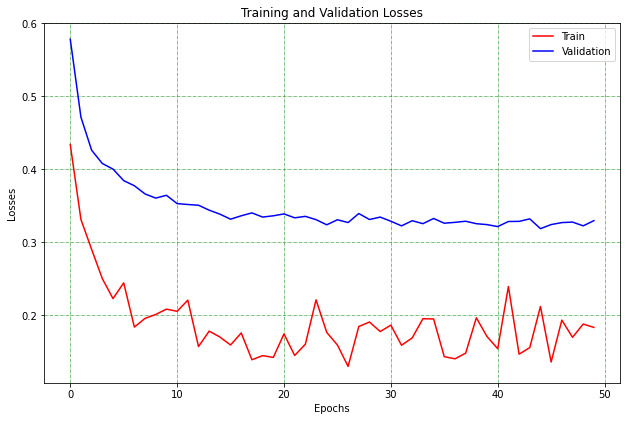

In [148]:
epochs = range(config['num_epoch'])
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(epochs, train_losses, color='r', label='Train', alpha=1)
ax.plot(epochs, val_losses, color='b', label='Validation', alpha=1)
ax.grid(color='g', ls='-.', lw=0.5)
ax.set_xlabel('Epochs')
ax.set_ylabel('Losses')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

### Evaluate on the test set
Now we can evaluate on the test set to see how our model perform:

In [149]:
# evaluate on test set
model.eval()
test_sparse_edge_index = test_sparse_edge_index.to(device)
test_edge_index = test_edge_index.to(device)
test_loss, test_recall, test_precision \
    = evaluation(model, 
                test_edge_index, 
                test_sparse_edge_index, 
                [train_edge_index, val_edge_index],
                config['topK'],
                config['lambda'])
    

print('Test set: train_loss: {:.4f}, recall: {:.4f}, precision: {:.4f}'\
        .format(test_loss, test_recall, test_precision))


Test set: train_loss: 0.3146, recall: 0.1315, precision: 0.0352


# Make New Recommendatios for a Given User

In [150]:
def predict(user_id, topK):
    '''
    Make top K recommendations to the user
    '''
    # read movie and uesr info
    model.eval()
    df = pd.read_csv(movie_path)
    movie_titles = pd.Series(df.title.values, index=df.movieId).to_dict()
    movie_genres = pd.Series(df.genres.values, index=df.movieId).to_dict()
    pos_items = get_positive_items(edge_index)
    user = user_mapping[user_id]
    user_emb = model.users_emb.weight[user]
    scores = model.items_emb.weight @ user_emb

    values, indices = torch.topk(scores, k=len(pos_items[user]) + topK)

    movies = [index.cpu().item() for index in indices if index in pos_items[user]]
    topk_movies = movies[:topK] 
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values())\
                                            .index(movie)] for movie in movies]
    titles = [movie_titles[id] for id in movie_ids]
    genres = [movie_genres[id] for id in movie_ids]

    print("User {:d} likes these movies:".format(user_id))
    for i in range(topK):
        print("title: {:s}, genres: {:s} ".format(titles[i], genres[i]))

    print('====================================================================')

    movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]]
    topk_movies = movies[:topK] 
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values())\
                                            .index(movie)] for movie in movies]
    titles = [movie_titles[id] for id in movie_ids]
    genres = [movie_genres[id] for id in movie_ids]

    print("Here are the movies that we think the user will enjoy:")
    for i in range(topK):
        print("title: {:s}, genres: {:s} ".format(titles[i], genres[i]))


### Try it out!
Now you can explore with different user ID (1 to 943) and the number of movies to recommend

In [151]:
predict(123, 10)

User 123 likes these movies:
title: Fight Club (1999), genres: Action|Crime|Drama|Thriller 
title: Pulp Fiction (1994), genres: Comedy|Crime|Drama|Thriller 
title: Shawshank Redemption, The (1994), genres: Crime|Drama 
title: Inception (2010), genres: Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX 
title: Silence of the Lambs, The (1991), genres: Crime|Horror|Thriller 
title: Matrix, The (1999), genres: Action|Sci-Fi|Thriller 
title: Star Wars: Episode IV - A New Hope (1977), genres: Action|Adventure|Sci-Fi 
title: Star Wars: Episode V - The Empire Strikes Back (1980), genres: Action|Adventure|Sci-Fi 
title: Inglourious Basterds (2009), genres: Action|Drama|War 
title: Seven (a.k.a. Se7en) (1995), genres: Mystery|Thriller 
Here are the movies that we think the user will enjoy:
title: Hush (1998), genres: Thriller 
title: Forrest Gump (1994), genres: Comedy|Drama|Romance|War 
title: Rosemary's Baby (1968), genres: Drama|Horror|Thriller 
title: Antitrust (2001), genres: Crime|Drama|Thri